# Client code for Heston and Bates calibration using MCMC

## 1. Heston calibration

The script below runs the calibration procedure for the parameters of the Heston model driving the dynamics of a stock 

$$dS_t = \mu S_t dt + \sqrt{V_t} S_t dW^{S}_t$$

with stochastic variance

$$dV_t = \kappa (\theta - V_t) dt + \sigma_V \sqrt{V_t} dW^{V}_t$$

and correlation between the driving Wiener processes $W^{S}_t$ and $W^{V}_t$

$$dW^{S}_t dW^{V}_t = \rho dt$$

In [4]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set(palette='viridis')
warnings.filterwarnings("ignore")

import jumpdiffcalibrator as jdcal

In [5]:
# ----- load data
stock_data = pd.read_csv("aapl_data.csv")["Adj Close"].values

# ----- set parameters
s0 = 100
nsteps = 2000
nsim = 100
r = 0.05
q = 0.02

In [6]:
# ================================== Heston calibration====================================
# ----- calibrate parameters
n_mcmc_steps = 10000
burn_in = 5000
heston_cal = jdcal.HestonCalibrator(price_series=stock_data, cost_of_carry=r - q)

start = time.time()
heston_cal.calibrate(n_mcmc_steps=n_mcmc_steps, burn_in=burn_in)
finish = time.time()
print(f"{(finish-start)/60} minutes elapsed")

# ----- get the calibrated parameters
all_params = heston_cal.params_dict
mu = all_params.get("mu_final")
kappa = all_params.get("kappa_final")
theta = all_params.get("theta_final")
sigma = all_params.get("volvol_final")
rho = all_params.get("rho_final")

# ----- get stock and variance trajectories
simulated_paths, simulated_variances = heston_cal.get_paths(s0=s0, nsteps=nsteps, nsim=nsim, risk_neutral=False)

100%|██████████| 9999/9999 [26:48<00:00,  6.22it/s]


26.805713017781574 minutes elapsed


The posterior parameters' dynamics is displayed in the figure below

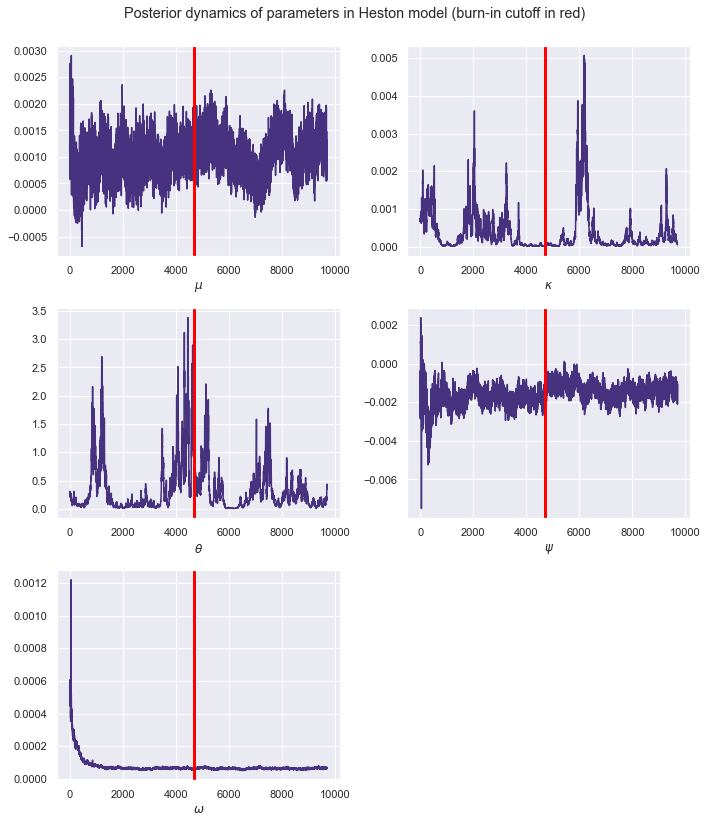

In [7]:
# ----- get the figures
# --- (a) parameters' dynamics
offset = 300
burn_in_pos = burn_in - offset
param_paths = heston_cal.all_params_array_full[offset:, :]
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes[0, 0].plot(param_paths[:, 0])
axes[0, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[0, 0].set_xlabel("$\\mu$")
axes[0, 1].plot(param_paths[:, 1])
axes[0, 1].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[0, 1].set_xlabel("$\\kappa$")
axes[1, 0].plot(param_paths[:, 2])
axes[1, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[1, 0].set_xlabel("$\\theta$")
axes[1, 1].plot(param_paths[:, 3])
axes[1, 1].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[1, 1].set_xlabel("$\\psi$")
axes[2, 0].plot(param_paths[:, 4])
axes[2, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[2, 0].set_xlabel("$\\omega$")
axes[2, 1].remove()
plt.suptitle('Posterior dynamics of parameters in Heston model (burn-in cutoff in red)')
plt.subplots_adjust(wspace=None, hspace=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Also get the simulated stock price paths

Text(0, 0.5, 'Stock price')

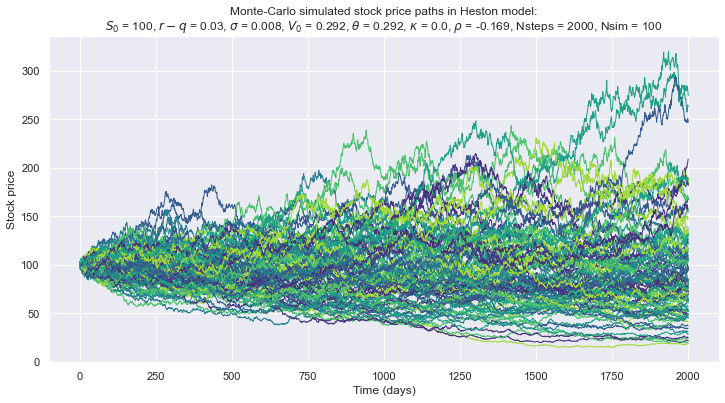

In [8]:
# --- (b) price paths
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps
bates_prices = ax.plot(days, simulated_paths.transpose(), linewidth=1)
ax.set_title("Monte-Carlo simulated stock price paths in Heston model:\n$S_0$ = {}, $r-q$ = {}, "
             "$\\sigma$ = {}, $V_0$ = {}, $\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, "
             "Nsteps = {}, Nsim = {}".format(*list(map(lambda x: round(x, 3), [s0, r - q, np.round(sigma, 3),
                                                                               np.round(theta, 3), np.round(theta, 3),
                                                                               np.round(kappa, 3), np.round(rho, 3),
                                                                               nsteps, nsim]))))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Stock price')

And the simulated variance paths

Text(0, 0.5, 'Variance process')

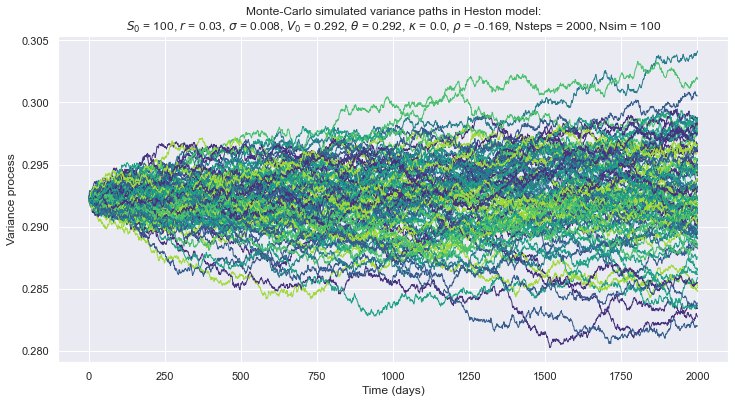

In [9]:
# --- (c) price variances
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps
bates_volas = ax.plot(days, simulated_variances.transpose(), linewidth=1)
ax.set_title("Monte-Carlo simulated variance paths in Heston model:\n$S_0$ = {}, $r$ = {}, "
             "$\\sigma$ = {}, $V_0$ = {}, $\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, "
             "Nsteps = {}, Nsim = {}".format(*list(map(lambda x: round(x, 3), [s0, r - q, np.round(sigma, 3),
                                                                               np.round(theta, 3), np.round(theta, 3),
                                                                               np.round(kappa, 3), np.round(rho, 3),
                                                                               nsteps, nsim]))))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Variance process')

## 2. Bates calibration

Now assume that the dynamics of a stock is driven by a jump-diffusion process:

$$dS_t = \left(\mu - \lambda (e^{\mu_S + 0.5 \sigma^2_S} - 1)\right) S_t dt + \sqrt{V_t} S_t dW^{S}_t + d\left(\sum_{j=1}^{N_t} S_{\tau_j^{-}}(e^{Z_j} - 1)\right)$$

with stochastic variance' dynamics similar to the Heston case:

$$dV_t = \kappa (\theta - V_t) dt + \sigma_V \sqrt{V_t} dW^{V}_t$$

and correlation between the driving Wiener processes $W^{S}_t$ and $W^{V}_t$

$$dW^{S}_t dW^{V}_t = \rho dt.$$

In this model, jumps are compound Poisson so that they arrive according to a Poisson process with intensity $\lambda$. The size of each jump is iid lognormally distributed with parameters $\mu_S$ and $\sigma^2_S$, conditioned on the arrival of a jump.

In [10]:
# ================================== Bates calibration ====================================
# ----- calibrate parameters
n_mcmc_steps = 10000
burn_in = 5000
bates_cal = jdcal.BatesCalibrator(price_series=stock_data, cost_of_carry=r - q)

start = time.time()
bates_cal.calibrate(n_mcmc_steps=n_mcmc_steps, burn_in=burn_in)
finish = time.time()
print(f"{(finish-start)/60} minutes elapsed")

# ----- get the calibrated parameters
all_params = bates_cal.params_dict
mu = all_params.get("mu_final")
kappa = all_params.get("kappa_final")
theta = all_params.get("theta_final")
sigma = all_params.get("volvol_final")
rho = all_params.get("rho_final")
mu_s = all_params.get("mu_s_final")
sigma_s = np.sqrt(all_params.get("sigma_sq_s_final"))
lambda_d = all_params.get("lambda_d_final")

# ----- simulate stock and variance trajectories
simulated_paths, simulated_variances = bates_cal.get_paths(s0=s0, nsteps=nsteps, nsim=nsim, risk_neutral=True)

100%|██████████| 9999/9999 [1:09:00<00:00,  2.41it/s]


69.00994411706924 minutes elapsed


Posterior parameters' dynamics:

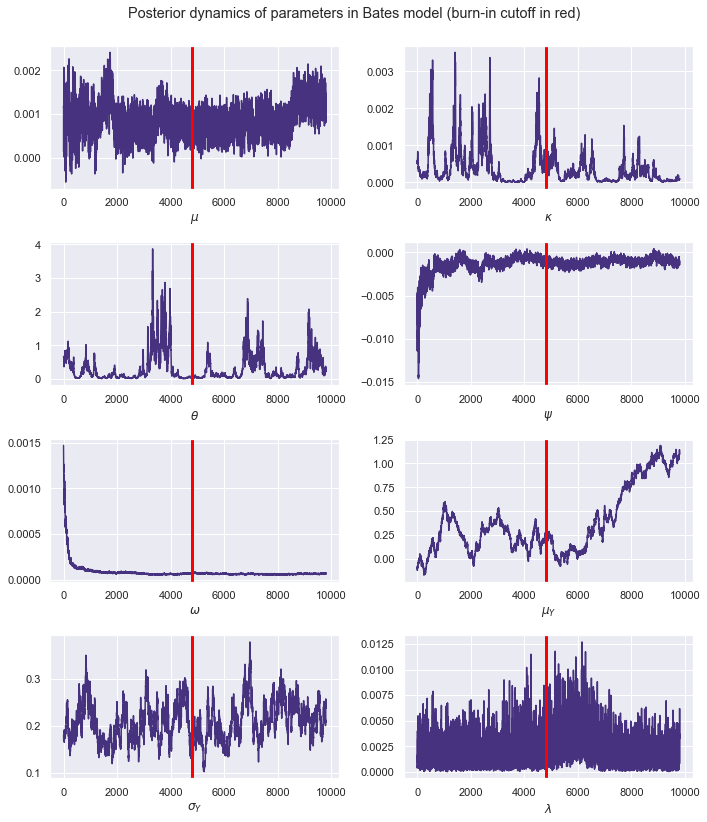

In [11]:
# ----- get the figures
# --- (a) parameters' dynamics
offset = 200
burn_in_pos = burn_in - offset
param_paths = bates_cal.all_params_array_full[offset:, :]
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
axes[0, 0].plot(param_paths[:, 0])
axes[0, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[0, 0].set_xlabel("$\\mu$")
axes[0, 1].plot(param_paths[:, 1])
axes[0, 1].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[0, 1].set_xlabel("$\\kappa$")
axes[1, 0].plot(param_paths[:, 2])
axes[1, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[1, 0].set_xlabel("$\\theta$")
axes[1, 1].plot(param_paths[:, 3])
axes[1, 1].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[1, 1].set_xlabel("$\\psi$")
axes[2, 0].plot(param_paths[:, 4])
axes[2, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[2, 0].set_xlabel("$\\omega$")
axes[2, 1].plot(param_paths[:, 5])
axes[2, 1].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[2, 1].set_xlabel("$\\mu_Y$")
axes[3, 0].plot(np.sqrt(param_paths[:, 6]))
axes[3, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[3, 0].set_xlabel("$\\sigma_Y$")
axes[3, 1].plot(param_paths[:, 7])
axes[3, 1].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[3, 1].set_xlabel("$\\lambda$")
plt.suptitle('Posterior dynamics of parameters in Bates model (burn-in cutoff in red)')
plt.subplots_adjust(wspace=None, hspace=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Simulated stock price paths:

Text(0, 0.5, 'Stock price')

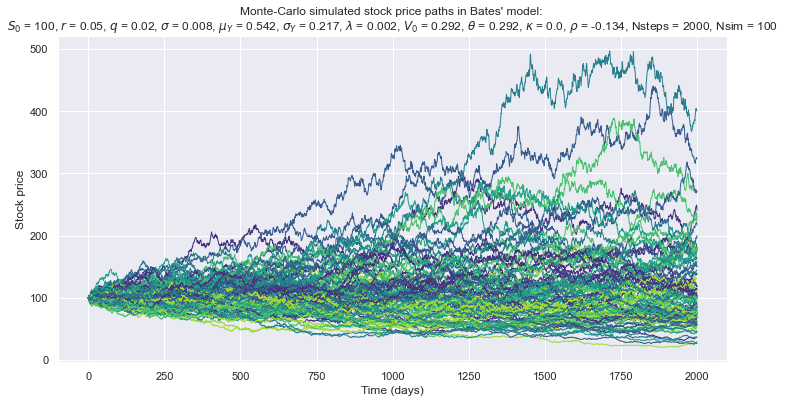

In [13]:
# --- (b) price paths
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps
bates_prices = ax.plot(days, simulated_paths.transpose(), linewidth=1)
ax.set_title("Monte-Carlo simulated stock price paths in Bates' model: \n$S_0$ = {}, $r$ = {}, $q$ = {}, "
             "$\\sigma$ = {}, $\\mu_Y$ = {}, $\\sigma_Y$ = {}, $\\lambda$ = {}, $V_0$ = {}, $\\theta$ = {}, "
             "$\\kappa$ = {}, $\\rho$ = {}, Nsteps = {}, Nsim = {}"
             .format(s0, r, q, np.round(sigma, 3), np.round(mu_s, 3), np.round(sigma_s, 3), np.round(lambda_d, 3),
                     np.round(theta, 3), np.round(theta, 3), np.round(kappa, 3), np.round(rho, 3), nsteps, nsim))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Stock price')

Simulated variance paths:

Text(0, 0.5, 'Variance process')

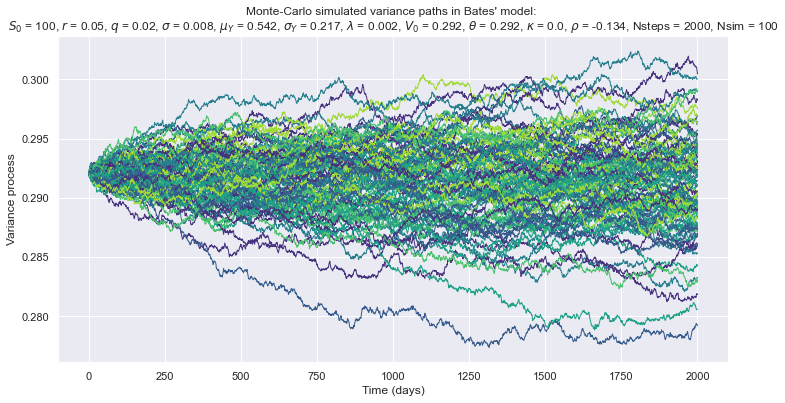

In [16]:
# --- (c) variance paths
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps
bates_volas = ax.plot(days, simulated_variances.transpose(), linewidth=1)
ax.set_title("Monte-Carlo simulated variance paths in Bates' model: \n$S_0$ = {}, $r$ = {}, $q$ = {}, "
             "$\\sigma$ = {}, $\\mu_Y$ = {}, $\\sigma_Y$ = {}, $\\lambda$ = {}, $V_0$ = {}, "
             "$\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, Nsteps = {}, Nsim = {}"
             .format(s0, r, q, np.round(sigma, 3), np.round(mu_s, 3), np.round(sigma_s, 3), np.round(lambda_d, 3),
                     np.round(theta, 3), np.round(theta, 3), np.round(kappa, 3), np.round(rho, 3), nsteps, nsim))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Variance process')